This notebook includes many simulation to study many statisitcal problems

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [5]:
rng = np.random.RandomState(8888)

In [7]:
n = 100
true_y = rng.normal(size=n,loc = 0,scale=3)
np.var(true_y)

8.862893068247667

In [15]:
temp = rng.normal(size = (100,5),loc = 5)
temp.sum(axis=0)

array([492.24610295, 502.85358726, 472.59419786, 494.11218604,
       506.62247862])

#### normalize so that columns sum to 1

In [16]:
temp_norm = temp/temp.sum(axis=0)
temp_norm.sum(axis=0)

array([1., 1., 1., 1., 1.])

#### normalize so that rows sum to 1

In [18]:
temp_norm_row = (temp.T / temp.sum(axis=1)).T
temp_norm_row.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### distinct, NA

In [19]:
df = pd.DataFrame({"x":[1,np.nan,3,5],'y':[2,5,1,3]})

In [21]:
df.isnull().sum(axis=0)

x    1
y    0
dtype: int64

In [26]:
df.nunique()

x    3
y    4
dtype: int64

#### np not na index

In [3]:
x = np.array([1,3,np.nan,5])
x[~np.isnan(x)]

array([1., 3., 5.])

Samples are correlated (some user's measurement were taken multiple times), bootstrap can correct it (assuming `true_y` is I.I.D)

__Recall from A/B Testing books: Having the randomization unit be coarser than the analysis uniut, such as randomizing by user and the click-through rate (by page) , will work, but requires more nuanced anlayses methods such as bootstrap or the delta method__.

- Bootstrap: We can sample 1 from each user_id (each user_id might mulitple page views) and estimate variance this way. Or later Bootstrap T method discussed later

- Delta method: Directly brute force calculation of variance on the user metrics. (see book)
- CUPED and other variance reduction techniques


In [8]:
n_replicates = 1000
out = rng.choice(true_y,size=(n_replicates,n))

In [9]:
np.mean(out.var(axis=1))

8.834754276635184

__Outlier effect on A/B testing, p-value of 0.32 and T-stat of 1.__

https://statisticaloddsandends.wordpress.com/2020/10/01/p-value-around-0-32-you-may-have-a-problem-with-outliers/

In [16]:
n = 100
a = rng.uniform(size = n)
b = rng.uniform(size = n)
stats.ttest_1samp(a,popmean= 1/2 )

Ttest_1sampResult(statistic=0.6196367030219052, pvalue=0.5369205035631737)

#### still same conclusion (insignificant) due to cancellation of the outlier in both numerator and denominator

Assume paired test

In [17]:
a[-1] = 10000
stats.ttest_1samp(a,popmean=1/2)

Ttest_1sampResult(statistic=1.0002202132496276, pvalue=0.31964245147070597)

In [18]:
stats.ttest_1samp(a-b,popmean=0)

Ttest_1sampResult(statistic=1.0004333959253777, pvalue=0.31953983594756175)

In [19]:
stats.ttest_rel(a,b)

Ttest_relResult(statistic=1.0004333959253777, pvalue=0.31953983594756175)

Assume independent two sample test

In [19]:
stats.ttest_ind(a,b)

Ttest_indResult(statistic=0.9995821663324865, pvalue=0.31873277752641305)

In [20]:
stats.ttest_ind(a,b,permutations = 1000)

Ttest_indResult(statistic=0.9995821663324865, pvalue=0.87)

__T-stats__

In [13]:
a.mean()/(a.std()/np.sqrt(n))

1.0102845891186012

### prop test (same P-value as chis-squared test)
$ Z^2 = \chi^2_1$

$H_0: p_1 - p_2$ =0

$H_1: Not Equal $

In [95]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([14, 20])
nobs = np.array([100, 100])
stat, pval = proportions_ztest(count, nobs)
stat, pval

(-1.129464917246783, 0.25870176105718956)

In [94]:
from scipy.stats import norm
pooled = count.sum()/nobs.sum()
stat_by_hand = (0.14 - 0.2) / np.sqrt(2 * pooled * (1-pooled)/nobs[0])
stat_by_hand, 2 * norm.cdf(stat_by_hand)

(-1.1294649172467832, 0.25870176105718945)

__Chi-squared__

In [70]:
contingency_table = np.array([14,86,20,80]).reshape(2,2)
contingency_table

array([[14, 86],
       [20, 80]])

In [81]:
exp_table = np.array([100*34/200,100*166/200,100*34/200,100*166/200]).reshape(2,2)
exp_table

array([[17., 83.],
       [17., 83.]])

In [84]:
chi_stat = ((contingency_table - exp_table) ** 2 / exp_table).reshape(-1).sum()

In [92]:
from scipy.stats import chi2

1 - chi2.cdf(chi_stat,df = 1)

0.25870176105718934

## Permutation test

Non-parametric test when the normality of tests do not hold

In [65]:
n = 100
treat_effect = 0.3
control = 1 + np.random.normal(size = n)
treatment = 1 + np.random.normal(size = n) + treat_effect

In [66]:
stats.ttest_ind(control,treatment)

Ttest_indResult(statistic=-2.817861558598173, pvalue=0.005324791945203552)

In [67]:
stats.ttest_ind(control,treatment,permutations = 10000)

Ttest_indResult(statistic=-2.817861558598173, pvalue=0.0041)

## Fisher’s Exact Test

Test for contingency table when sample size is small (or large), in particular, the P-value can be calculated exactly, rather than relying on an approximation that becomes exact in the limit as the sample size grows to infinity, as with many statistical tests. 
https://en.wikipedia.org/wiki/Fisher%27s_exact_test

||Men|Women|
|--|--|--|
|Study|1|9|
|Non Study|11|3|

#### less and greater based on table ordering

In [23]:
from scipy.stats import fisher_exact
fisher_exact(table=[[1,9],[11,3]], alternative="less")

(0.030303030303030304, 0.0013797280926100372)

In [26]:
fisher_exact(table=[[9,1],[3,11]], alternative="greater")

(33.0, 0.0013797280926100372)

## Bootstrap with parallel

### non-parametric bootstrap

In [3]:
from joblib import Parallel, delayed # for parallel processing
import numpy as np
x = np.random.normal(size = 100, scale =10)
bootstrap_samples = 100
def std_sample(x):
    x = np.random.choice(x,size = len(x),replace = True)
    return(x.std())
out = Parallel(n_jobs = 10)(delayed(std_sample)(x) for _ in range(bootstrap_samples))

np.quantile(out,[0.025,0.5,0.975])

array([ 7.83456167,  8.84695193, 10.07557688])

In [6]:
from joblib import delayed, Parallel
import scipy.stats as ss
import numpy as np

In [61]:
np.random.seed(8888)
x = ss.cauchy.rvs(size = 100)
n_boot_samples = 5000
def var_sample(x):
    x_boot = np.random.choice(x, size = len(x), replace = True)
    return np.median(x_boot)

In [62]:
boot_median = Parallel(n_jobs = 10)(delayed(var_sample)(x) for _ in range(n_boot_samples))
np.var(boot_median)

0.024537052995451843

### Check the lecture notes on bootstrap for math detail

### Parametric bootstrap

Use sample statistic and assumes a parametric distribution.

Example: Use the sample median and assummes true population is a Cauchy, do bootstrap and construct interval

In [63]:
np.random.seed(8888)
x = ss.cauchy.rvs(size = 100)
n_boot_samples = 5000
sample_median = np.median(x)
def var_sample(x0):
    x_par = ss.cauchy.rvs(size = 100,loc = x0)
    return np.median(x_par)

In [64]:
para_bootstrap = Parallel(n_jobs = 10)(delayed(var_sample)(sample_median) for _ in range(n_boot_samples))
np.var(para_bootstrap)

0.02447355007653579

### Non parametric Bootstrap percentile vs. T-method

In [20]:
rng = np.random.RandomState(0)
n = 500
p = 1
x = rng.normal(size=(n,p))
beta = [1,5]
y = np.dot(np.concatenate((np.repeat(1,n)[:,None],x),axis=1),beta) + rng.normal(size =n)

In [21]:
import pandas as pd
data = pd.DataFrame(np.concatenate((y[:,None],x),axis=1),columns = ["y",'x'])
              

#### percentile CI method

In [22]:
## percentile CI method
import statsmodels.formula.api as smf
n_boot = 1000
def get_ratio_boot(data):
    coef = smf.ols("y~x",data = data).fit().params
    return coef[1]/coef[0]

out = Parallel(n_jobs = 10)(delayed(get_ratio_boot)(data.sample(frac = 1, replace = True)) for _ in range(n_boot))

In [23]:
np.quantile(out,[0.025,0.975])

array([4.85929696, 5.82460528])

#### T method

In [24]:
import statsmodels.formula.api as smf
n_boot = 1000
model = smf.ols("y~x",data = data).fit()
model_coef = model.params
coef_cov = model.cov_params()
theta_hat = model_coef[1] / model_coef[0]
sigma2_delta = theta_hat**2 * (coef_cov.iloc[1,1]/(model_coef[1]**2)  + coef_cov.iloc[0,0]/(model_coef[0]**2) - 2 * (coef_cov.iloc[1,0])/ (model_coef[0] * model_coef[1]))

def get_ratio_boot(data,theta_hat):
    model = smf.ols("y~x",data = data).fit()
    coef = model.params
    coef_cov = model.cov_params()
    theta_hat_boot =  coef[1]/coef[0]
    sigma2_delta = theta_hat_boot**2 * (coef_cov.iloc[1,1]/(coef[1]**2)  + coef_cov.iloc[0,0]/(coef[0]**2) - 2 * (coef_cov.iloc[1,0])/ (coef[0] * coef[1]))
    return ((theta_hat_boot-theta_hat) / np.sqrt(sigma2_delta))

out = Parallel(n_jobs = 10)(delayed(get_ratio_boot)(data.sample(frac = 1, replace = True), theta_hat) for _ in range(n_boot))

In [26]:
t_quant = np.quantile(out,[0.025,0.975])
theta_hat + t_quant * np.sqrt(sigma2_delta)

array([4.76660753, 5.76852671])

## Given U(0,1), sample discrete distribution (a,b)

<AxesSubplot:ylabel='Count'>

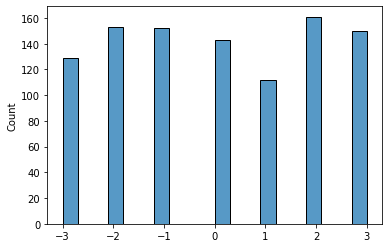

In [130]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def map_u_to_discrete(a,b,n=1000):
    x = np.random.uniform(size = n)
    y = np.linspace(a,b,b-a+1)
    buckets = np.linspace(0,1,b-a+2)[1:] ## same as below question
    return [y[np.where(x_i<=buckets)[0][0]] for x_i in x]
out = map_u_to_discrete(-3,3)
sns.histplot(out,bins=20)

## Given U(0,1) generate binomial(n = 4, p =5/8)

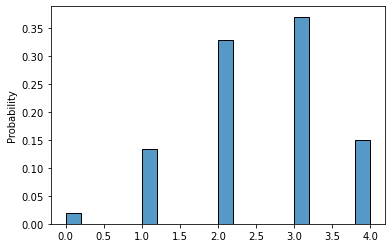

In [11]:
from scipy.stats import binom

p = binom.cdf(k= np.linspace(0,4,5),n=4,p=5/8)
x = np.random.uniform(size = 10000)
y_samples = [np.where(x_i <= p)[0][0] for x_i in x]
sns.histplot(y_samples,bins=20, stat = 'probability');

In [10]:
binom.pmf(k= np.linspace(0,4,5),n=4,p=5/8)

array([0.01977539, 0.13183594, 0.32958984, 0.36621094, 0.15258789])

In [124]:
p

array([0.01977539, 0.15161133, 0.48120117, 0.84741211, 1.        ])

## OLS R style formula trick 

In [20]:
import statsmodels.formula.api as smf
feature_name = ['x1','x2','x3']
formula = "y~"+"+".join(feature_name)
print(formula)
#model = smf.ols(formula,data = data).fit()

y~x1+x2+x3


## Sequential probability ratio test 
https://en.wikipedia.org/wiki/Sequential_probability_ratio_test
https://towardsdatascience.com/experiments-peeking-and-optimal-stopping-954506cec665

$H_0 = \theta_0$

$H_1 = \theta_1$ 

where $\theta_1 > \theta_0$

Likelihood ratio is taken by $ \frac{L(\theta_1)}{L(\theta_0)}$

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.stats import expon
import matplotlib.pyplot as plt

In [4]:
def SLRT(alpha = 0.05, beta = 0.2, true_diff = 0.1, theta_alt = 0.1, total_n = 1000, n_stream = 1):
    a = np.log( beta / (1-alpha) )
    b = np.log( (1-beta) / alpha )
    Y = np.array([])
    LR = np.repeat(0.0,int(total_n/n_stream))
    decision = np.nan
    for idx, i in enumerate(range(0,total_n,n_stream)):
        y_new = norm.rvs(loc=true_diff,scale=1,size=n_stream)
        Y = np.concatenate((Y,y_new))
        LR[idx] = norm.logpdf(y_new,loc=theta_alt,scale=1).sum() - norm.logpdf(y_new,loc=0,scale=1).sum()
        if sum(LR) < a:
            decision = 0
            break
        elif sum(LR) > b:
            decision = 1
            break 
    plt.plot(np.cumsum(LR))
    plt.axhline(y=a, color='r', linestyle='-')
    plt.axhline(y=b, color='r', linestyle='-')
    return idx+1, decision

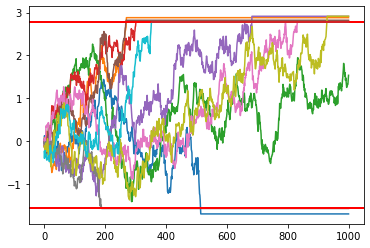

In [5]:
n_total = np.array([])
decision = np.array([])
for i in range(10):
    n, d = SLRT()
    n_total = np.append(n_total,n)
    decision =  np.append(decision, d)

In [127]:
np.nanmean(decision) ## power

0.7708333333333334

In [128]:
np.mean(n_total)

391.25

## Sample with weights

In [129]:
import numpy as np

In [152]:
rng = np.random.RandomState(0)
weight = np.array([1,2,3,4,5])
samples = rng.choice(5,p=weight/sum(weight),size=1000) ## In R, you don't have to normalize

In [153]:
import collections
summary = collections.Counter(samples)

In [156]:
dict(sorted(summary.items(), key = lambda x: x[0]))

{0: 66, 1: 134, 2: 215, 3: 254, 4: 331}